In [1]:
import math
import pandas as pd
import networkx as nx
import numpy as np
import operator
from haversine import haversine

from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.pyplot as plt

from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

import gurobipy

%matplotlib inline

### 2. Calculate 4 centrality measures and identify the 2 most important nodes according to each measure. Explain what the measure is trying to capture and whether it is appropriate in this context.

Before calculating the centrality measures, we define a helper function that creates a graph from an adjacency matrix. The function takes a unweighted and weighted adjacency matrix as input. If the unweighted adjacency matrix contains more edges than the weighted adjacency matrix the function adds 0-weighted edges to the final graph.

In [2]:
def graphAdjMatrix(nonweightedAdjMat, weightedAdjMat):    
    G1 = nx.Graph(nonweightedAdjMat)
    G2 = nx.Graph(weightedAdjMat)
    
    G1_edge = G1.edges()
    G2_edge = G2.edges()
    
    if len(G1_edge) > len(G2_edge):
        for (src, dest) in G1_edge:
            if (src, dest) not in G2_edge:
                G2.add_edge(src, dest, weight = 0)
                
    return G2

Next we load the data and use the function defined above to create a weighted graph.

In [3]:
adjMatrix = np.loadtxt("HW2_problem 2.txt", dtype=int)

# Use graphAdjMatrix() function to read in both 0-1 and weighted adjacency matrices
# Ensure that no 0-weighted edges are missed out
adjShape = np.shape(adjMatrix)
graph = graphAdjMatrix(adjMatrix[0 : adjShape[1], ], adjMatrix[adjShape[1] : adjShape[0], ])

We can now move on to calculating the centrality measures.

#### Betweenness centrality:

$$ g(v) = \sum_{j \neq k \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}$$

In [4]:
betweenness = nx.betweenness_centrality(graph)
sorted(betweenness, key=betweenness.get, reverse=True)[:2]

[0, 33]

These two nodes are the two for which the highest sum of fractions of shortest paths for all pairs run through these nodes. Implying that they are "between" the most pairs, and so have a high importance within the network.

The reason we use (weight = None) in the function and calculate the betweenness centrality for an "unweighted graph" is that the edge weights represent the friendship strength between two nodes. The shortest path in this case will be defined as the "least friendly path" between two nodes. Hence we calculate the betweenness centrality based on unweighted graph. In this case, the shortest path will be the "shortest route" to reach a person via friends (regardless of the friendship strength).

#### Current-flow closeness centrality:

$$ d_i = \frac{\sum_jR_{i,j}}{n} , c_i = \frac{1}{d_i} = \frac{n}{\sum_jR_{i,j}}$$

In [5]:
flowcloseness = nx.current_flow_closeness_centrality(graph, weight = 'weight')
sorted(flowcloseness, key=flowcloseness.get, reverse=True)[:2]
# sorted(nx.current_flow_closeness_centrality(graph, weight = 'weight').items(), reverse = True, key = operator.itemgetter(1))

[33, 0]

The current-flow closeness centrality (similar to Information Centrality) takes into account not just the shortest paths but all possible paths, and identifies the nodes through which the highest amount of information (or current for electrical networks) is passed. In this case we get the two nodes 0 and 33, with the highest information flow centrality. This is similar to betweenness but node 0 has higher centrality when you only take into account shortest paths, and node 33 has higher centrality when you take into account all paths (which may be more robust).

#### Eigenvector centrality:

$$ x_{v} = \frac{1}{\lambda} \sum_{t \in M(v)} x_{t} = \frac{1}{\lambda} \sum_{t \in G} a_{v,t}x_{t} $$

In [6]:
eigenvector = nx.eigenvector_centrality(graph, weight = 'weight')
sorted(eigenvector, key=eigenvector.get, reverse=True)[:2]
# sorted(nx.eigenvector_centrality(graph, weight = 'weight').items(), reverse = True, key = operator.itemgetter(1))

[33, 2]

Eigenvector centrality takes into account the fact that the importance of a node's neighbours is an input into the importance of that node. We can see here that node 2 has a high eigenvector centrality because it has important neighbours (e.g. node 0, and 32) whereas node 0 has lower importance, most likely because it has lots of neighbours of lower importance.

#### Closeness centrality:

$$ C(x) = \frac{1}{\sum_{y} d(y,x)} $$

In [7]:
closeness = nx.closeness_centrality(graph)
sorted(closeness, key=closeness.get, reverse=True)[:2]

[0, 2]

These two nodes are the two that have the lowest sum distance to all other nodes. Implying that they are the "closest" to the most other nodes. The 0 node is included here, but the 33rd node is 3rd, implying that node 2 is "closer" to the rest of the network as a whole than node 33.

The reason we use (distance = None) in the function and calculate the closeness centrality for an "unweighted graph" is that the edge weights represent the friendship strength between two nodes. The shortest path in this case will be defined as the "least friendly path" between two nodes. Hence we calculate the closeness centrality based on unweighted graph. In this case, the shortest path will be the "shortest route" to reach a person via friends (regardless of the friendship strength).

#### Degree centrality:

$$ C_D(v) = deg(v) $$

In [8]:
degree = nx.degree_centrality(graph)
sorted(degree, key=degree.get, reverse=True)[:2]
# sorted(nx.degree_centrality(graph).items(), reverse = True, key = operator.itemgetter(1))

[33, 0]

These two nodes are the two that have the highest number of neighbours. This simple metric for centrality identifies nodes 33 and 0 as the highest "importance" for this network.

In order to better illustrate the differences in centrality measures we plot them.

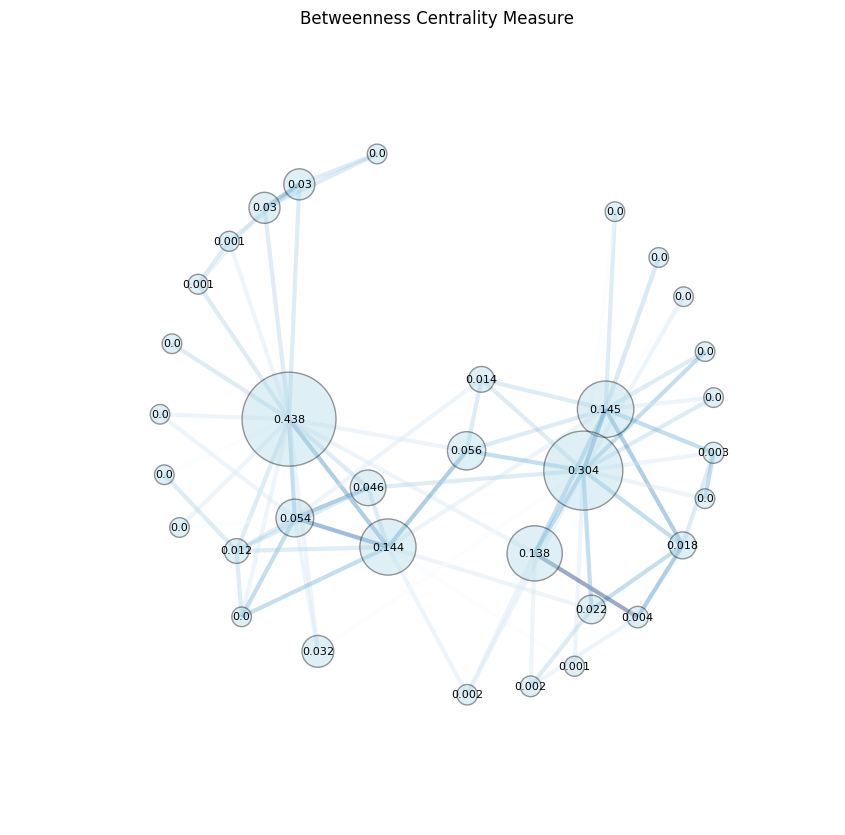

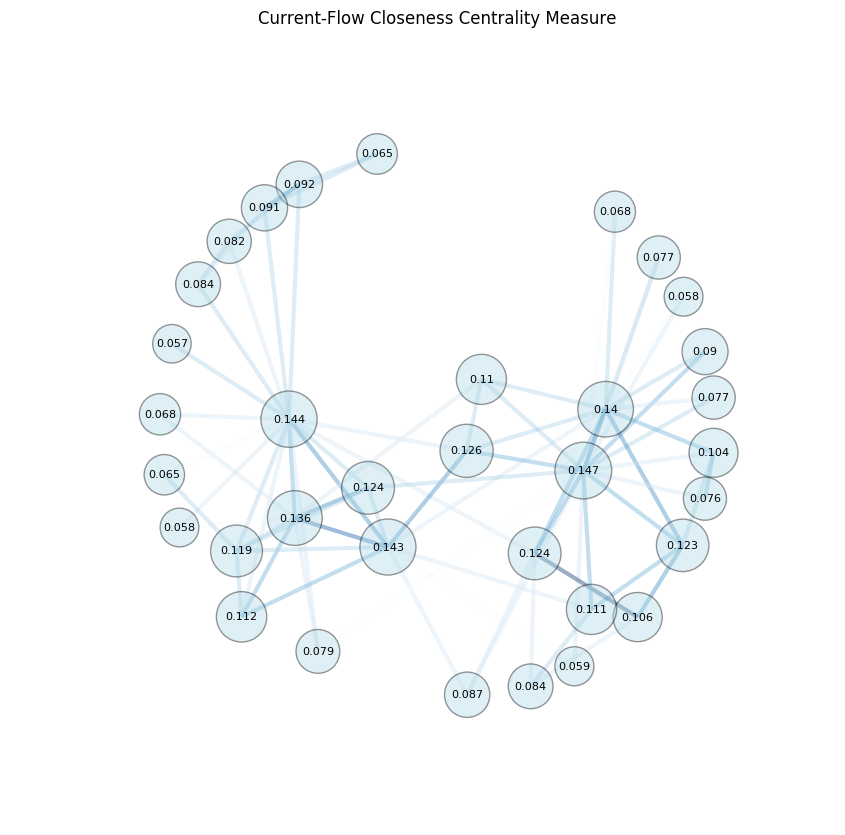

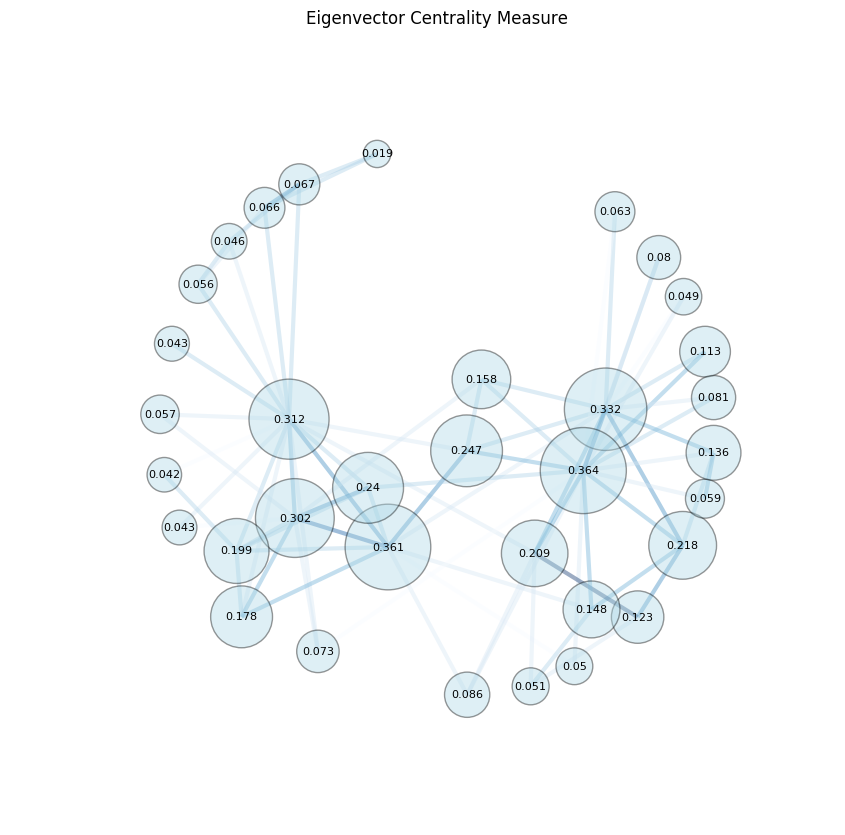

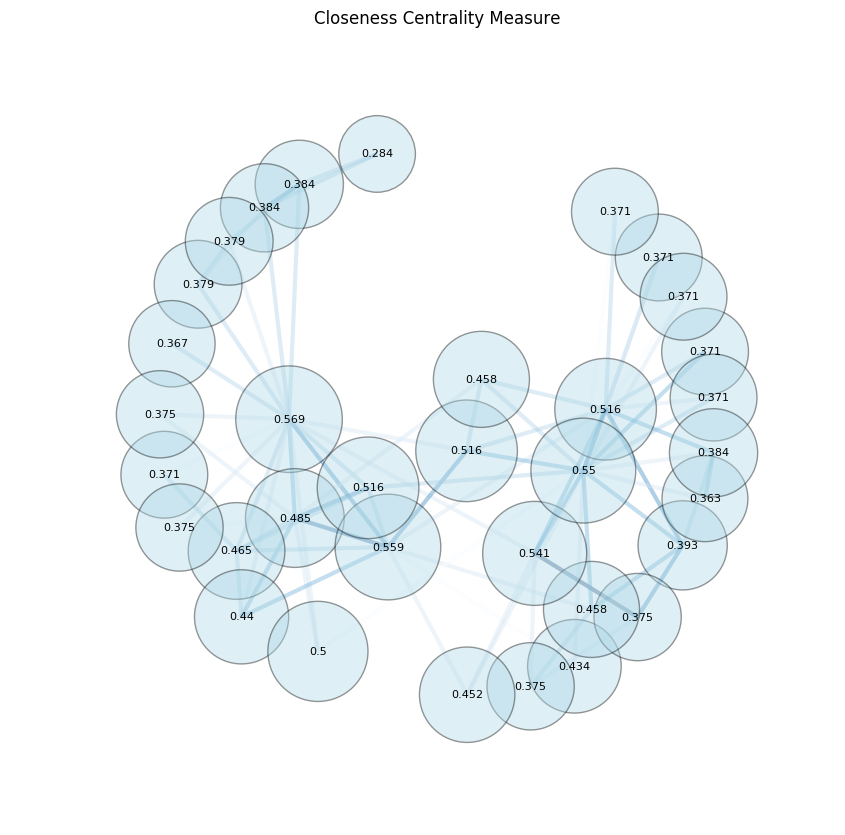

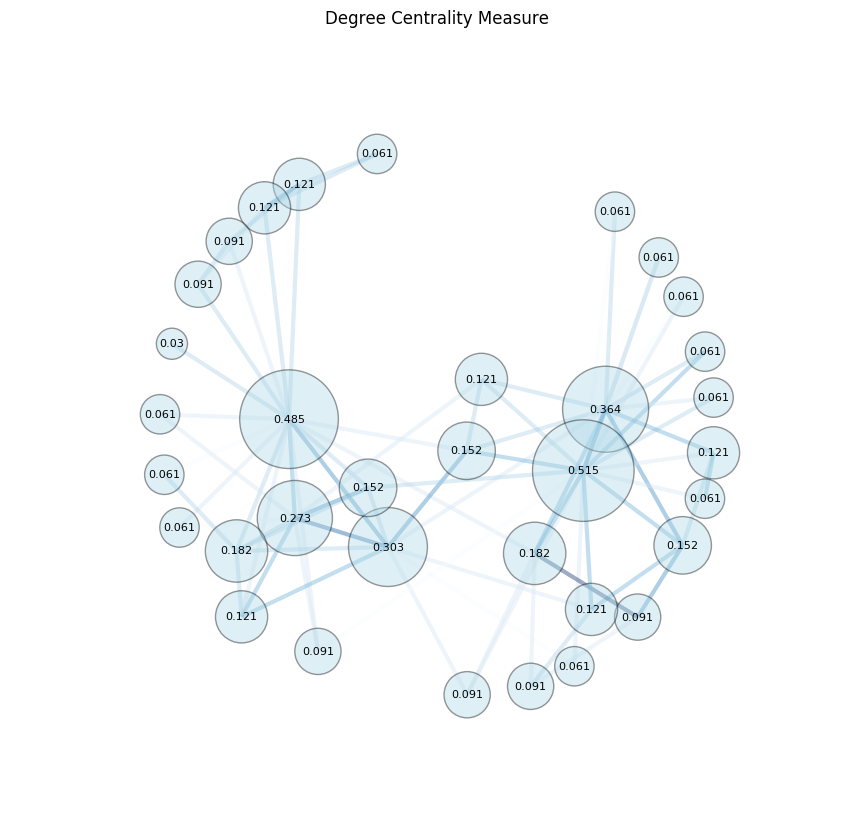

In [9]:
nx.set_node_attributes(graph, 'Betweenness', betweenness)
nx.set_node_attributes(graph, 'Current-Flow Closeness', flowcloseness)
nx.set_node_attributes(graph, 'Eigenvector', eigenvector)
nx.set_node_attributes(graph, 'Closeness', closeness)
nx.set_node_attributes(graph, 'Degree', degree)
centrality_measures = ['Betweenness', 'Current-Flow Closeness', \
                       'Eigenvector', 'Closeness', 'Degree']

pos = nx.spring_layout(graph, k = .25, iterations = 2000)
for cm in centrality_measures:
    # Visualise the graph
    plt.figure(figsize = (10, 10))
    plt.title(cm + ' Centrality Measure')
    labs = nx.get_node_attributes(graph, cm)
    for key, value in labs.items(): 
        labs[key] = round(value, 3)
    nx.draw(graph, pos, node_color = 'lightblue', edge_color = [d['weight'] for (u, v, d) in graph.edges(data = True)], 
            width = 3, edge_cmap=plt.cm.Blues, alpha = .4, 
            node_size = np.add(np.multiply(list(nx.get_node_attributes(graph, cm).values()), 10000), 200))
    nx.draw_networkx_labels(graph, pos, labels =labs, font_color = 'black', font_size = 8)
    #nx.draw_networkx_edge_labels(Gw, pos, edge_labels = nx.get_edge_attributes(Gw, 'weight'), font_size = 8)
    plt.show()
    plt.close()

### 3.a Plot the latitude and longitude as a scatter plot using a drawing package 

We first load the data and transform it into latitude and longitude coordinates. To calculate the distances between each city pairs we define a function that returns distance matrices using Haversine and Euclidean distances.

In [10]:
# Read the coordinates from file
coordDF = pd.read_table('HW2_tsp.txt', sep = ' ', header = None, skiprows = 10, 
                        index_col = 0, names = ["x", "y"])

# Matrix containing (x, y) as Cartesian coordinates pair
coordMat = coordDF.as_matrix()
# Matrix containing (lat, long) as Latitude & Longitude pair
coordMat_latlong = coordMat / 1000
# Dataframe containing (lat, long) as Latitude & Longitude pair
coordDF_ = coordDF
coordDF_['x'] = coordDF['x'] / 1000
coordDF_['y'] = coordDF['y'] / 1000

# Function to calculate distance matrices
def calcDistance(coordMat, coordMat_latlong):        
    # Initialize the Euclidean Distance Matrix
    distMat = np.zeros((coordMat.shape[0], coordMat.shape[0]))
    # Initialize the Haversine Distance Matrix
    havDistMat = np.zeros((coordMat.shape[0], coordMat.shape[0]))
    
    for i in range(coordMat.shape[0]):
        for j in range(i + 1, coordMat.shape[0]):
            # Update Euclidean distance between city i & j
            distMat[i][j] = math.sqrt((coordMat[j][0] - coordMat[i][0])**2 + (coordMat[j][1] - coordMat[i][1])**2)
            distMat[j][i] = distMat[i][j]
            # Update Haversine distance between city i & j
            havDistMat[i][j] = haversine((coordMat_latlong[i][0], coordMat_latlong[i][1]), (coordMat_latlong[j][0], coordMat_latlong[j][1]))
            havDistMat[j][i] = havDistMat[i][j]
            
    distDF = pd.DataFrame(distMat, index = coordDF.index, columns = coordDF.index)
    havDistDF = pd.DataFrame(havDistMat, index = coordDF.index, columns = coordDF.index)
    return distDF, havDistDF

# Get Euclidean Distance and Haversine Distance
eucDistDF, havDistDF = calcDistance(coordMat, coordMat_latlong)
havDistMat = havDistDF.as_matrix()

The first map shows Djibouti's locations in relation to the African continent. The red dots represent the cities the traveling salesman needs to visit.

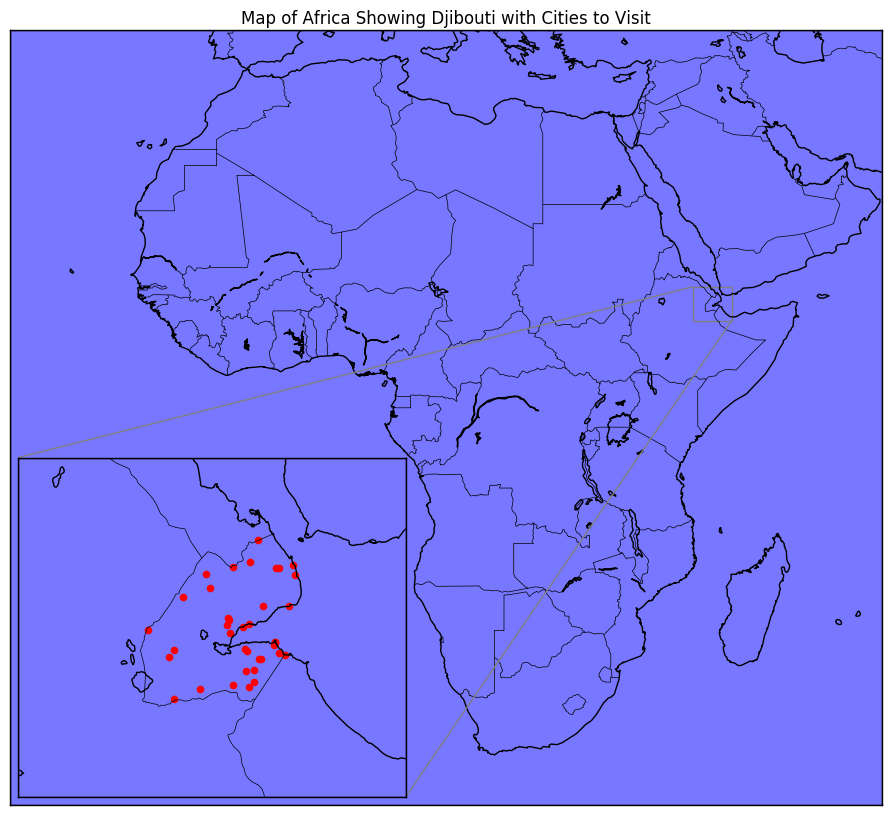

In [11]:
fig = plt.figure()
fig = plt.figure(figsize=(20,10))
plt.title('Map of Africa Showing Djibouti with Cities to Visit')

# Create subplot
ax = fig.add_subplot(111)

map1 = Basemap(llcrnrlon=-30,llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40, resolution = 'l')

# Draw country borders on the map
map1.drawcountries()

map1.drawmapboundary(fill_color='#7777ff')
map1.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
map1.drawcoastlines()

y, x = map1(coordDF_['y'].values, coordDF_['x'].values)

# adjust size and location of subplot
axins = zoomed_inset_axes(ax, 10, loc=3)
axins.set_xlim(-20, 0)
axins.set_ylim(3, 18)

plt.xticks(visible=False)
plt.yticks(visible=False)

map2 = Basemap(llcrnrlon=40.5,llcrnrlat=10,urcrnrlon=44.5,urcrnrlat=13.5, ax=axins, resolution = 'h')
map2.drawmapboundary(fill_color='#7777ff')
map2.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
map2.drawcoastlines()
map2.drawcountries()

map2.scatter(y, x, color= 'r')

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show();

The following map represents a close-up of Djibouti including the cities to be visited by the traveling salesman.

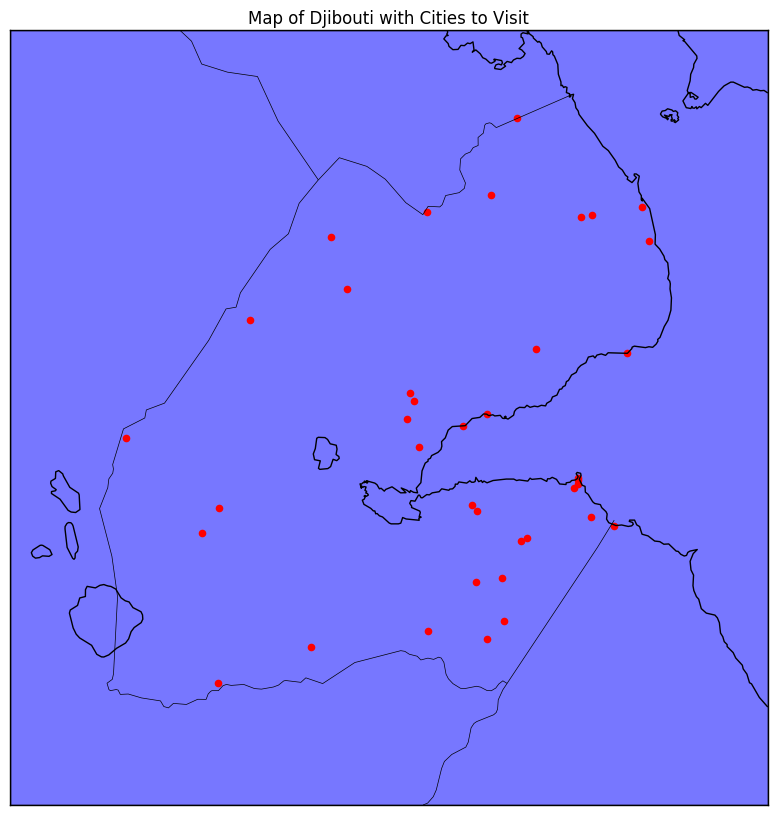

In [12]:
fig = plt.figure(figsize=(20,10))
plt.title('Map of Djibouti with Cities to Visit')

plt.xticks(visible=False)
plt.yticks(visible=False)

map3 = Basemap(llcrnrlon=41.5,llcrnrlat=10.65,urcrnrlon=43.7,urcrnrlat=12.9, resolution = 'h')

map3.drawcountries()

map3.drawmapboundary(fill_color='#7777ff')
map3.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
map3.drawcoastlines()

map3.scatter(y, x, color= 'r')

plt.show()

### 3.b Use the or-tools traveling salesman routine to find a tour of the 38 cities.

Before solving the traveling salesman problem, we create a function to plot our results. This will allow us to easily plot the results from Or-tools and Gurobi.

In [26]:
def plotPath(worldCoordinates, tour, filename):
    # Plot the World map around Djibouti
    mapDjibouti = Basemap(projection = 'mill', 
                          llcrnrlat = worldCoordinates.min(axis = 0)[0] - 0.3, 
                          llcrnrlon = worldCoordinates.min(axis = 0)[1] - 0.3, 
                          urcrnrlat = worldCoordinates.max(axis = 0)[0] + 0.3, 
                          urcrnrlon = worldCoordinates.max(axis = 0)[1] + 0.3, 
                          resolution = 'h')
    # Draw coastline, country borders, and background image
    mapDjibouti.drawcountries()
    mapDjibouti.drawmapboundary(fill_color='#7777ff')
    mapDjibouti.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
    mapDjibouti.drawcoastlines()
    
    # Plot all the cities in Djibouti
    xPlot, yPlot = mapDjibouti(worldCoordinates[ : , 1], worldCoordinates[ : , 0]) # x is longitude, y is latitude
    mapDjibouti.plot(xPlot, yPlot, 'ro', markersize = 5)
    
    k = 1
    for (lat, long) in worldCoordinates:
        xlabel, ylabel = mapDjibouti(long, lat)
        plt.text(xlabel, ylabel, k, fontsize = 15)
        k += 1    
    
    xs = []
    ys = []
    
    # Plot the optimal tour
    for i in tour:    
        x, y = mapDjibouti(worldCoordinates[i - 1, 1], worldCoordinates[i - 1, 0])
        xs.append(x)
        ys.append(y)
    
    print('Route in', filename, ':', tour)
    mapDjibouti.plot(xs, ys, color = 'blue', linewidth = 1, label = 'Tour')
    
    # Set the title and save to PDF
    if tour == ortoolsTour:
        plt.title('Or-tools Djibouti TSP solution')
    else:
        plt.title('Gurobi Djibouti TSP solution')
        
    plt.savefig(filename)
    plt.show()
    plt.close()

Using Google's or-tools, we calculate the shortest tour through the 38 cities. As or-tools returns different solutions for different starting points, we create a loop that iterates through all the cities and set each as starting point. Only the shortest tour is returned. The tour generated by or-tools will be evaluated under point d.

In [14]:
class CreateDistanceCallback(object):
    """Create callback to calculate distances between points."""
    def __init__(self, distMat):
        """Array of distances between points."""
        self.matrix = distMat

    def Distance(self, from_node, to_node):
        return self.matrix[from_node][to_node]

def ortools(distMat):
    
    tsp_size = distMat.shape[0]
    selected = []
    bestRoute = ''
    
    # Create routing model
    if tsp_size > 0:      
        
        bestObj = np.Inf
        
        search_parameters = pywrapcp.RoutingModel.DefaultSearchParameters()        
        # Setting first solution heuristic: the
        # method for finding a first solution to the problem.
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
        
        # Create the distance callback, which takes two arguments (the from and to node indices)
        # and returns the distance between these nodes.        
        dist_between_nodes = CreateDistanceCallback(distMat)
        dist_callback = dist_between_nodes.Distance            
        
        for i in range(tsp_size):
            # TSP of size tsp_size
            # Second argument = 1 to build a single tour (it's a TSP).
            # Nodes are indexed from 0 to tsp_size - 1. By default the start of
            # the route is node 0.
            routing = pywrapcp.RoutingModel(tsp_size, 1, i)
            
            routing.SetArcCostEvaluatorOfAllVehicles(dist_callback)
            # Solve, returns a solution if any.
            assignment = routing.SolveWithParameters(search_parameters)
            if assignment:
                if assignment.ObjectiveValue() < bestObj:
                    bestObj = assignment.ObjectiveValue()
                    route_number = 0
                    index = routing.Start(route_number) # Index of the variable for the starting node.
                    bestRoute = ''
                    selected = []
                    while not routing.IsEnd(index):
                        # Convert variable indices to node indices in the displayed route.
                        bestRoute += str(routing.IndexToNode(index) + 1) + ' -> '
                        selected.append(routing.IndexToNode(index) + 1)
                        index = assignment.Value(routing.NextVar(index))
                        
                    bestRoute += str(routing.IndexToNode(index) + 1)
                    selected.append(routing.IndexToNode(index) + 1)
                    
            else:
                print('No solution found for starting node:', i)                  
            
    else:
        print('Specify an instance greater than 0.')
        
    return selected

ortoolsTour = ortools(havDistMat)

### 3.c Use the Gurobi solver to find a tour of the 38 cities.

We now solve the same traveling salesman problem using the Gurobi solver.

In [15]:
def findSubTour(selectedPairs):
    notVisited = np.unique(selectedPairs).tolist()
    neighbours = [notVisited[0]]
    visited = []

    while (len(neighbours) > 0):
        currCity = neighbours.pop()
        neighbours1 = [j for i, j in selectedPairs.select(currCity, '*') if j in notVisited and j not in neighbours]
        neighbours2 = [i for i, j in selectedPairs.select('*', currCity) if i in notVisited and i not in neighbours]
        notVisited.remove(currCity)
        visited.append(currCity)
        while len(neighbours1) > 0:
            neighbours.append(neighbours1.pop())
        while len(neighbours2) > 0:
            neighbours.append(neighbours2.pop())

    return visited, notVisited           

# Add lazy constraints to eliminate subtours (for Qn 3c: Gurobi)
def elimSubTour(model, where):
    if where == gurobipy.GRB.Callback.MIPSOL:
        vals = model.cbGetSolution(model._xVar)
        selectedPairs = gurobipy.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)
        visited, notVisited = findSubTour(selectedPairs)
        # If there is subtour, add constraint: the cut should have at least 2 edges
        if len(notVisited) > 0:
            model.cbLazy(gurobipy.quicksum(model._xVar[i, j] for j in notVisited for i in visited if i < j) + 
                                           gurobipy.quicksum(model._xVar[j, i] for j in notVisited for i in visited if i > j) 
                                           >= 2)

In [16]:
# Initialize Gurobi Model
tspModel = gurobipy.Model('DjiboutiTSP')
# All distinct city pairs
tuplelist = [(x,y) for x in range(1, coordMat.shape[0] + 1) for y in range(1, coordMat.shape[0] + 1) if x < y]
# Distance between city pairs
distlist = [havDistMat[x - 1, y - 1] for x in range(1, coordMat.shape[0] + 1) for y in range(x + 1, coordMat.shape[0] + 1)]
# Declare Decision Variables (with Objective Coefficients)
xVar = tspModel.addVars(tuplelist, obj = distlist, vtype = gurobipy.GRB.BINARY, name = 'x')

# Constraints: Degree = 2
tspModel.addConstrs((sum(xVar.select(i, '*')) + sum(xVar.select('*', i))) == 2 for i in range(1, coordMat.shape[0] + 1))

# Enable Lazy Constraints
tspModel.setParam("LazyConstraints", 1)
# Store the decision variables as private variable (for access later)
tspModel._xVar = xVar
# Solve the TSP using elimSubTour as a sub-routine
tspModel.optimize(elimSubTour)

# Get the selected path
vals = tspModel.getAttr('x', xVar)
gurobiSelected = gurobipy.tuplelist((i, j) for i, j in vals.keys() if vals[i,j] > 0.5)

gurobiTour = findSubTour(gurobiSelected)[0]
gurobiTour.append(gurobiTour[0]) # Return to the first city for complete tour

Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 38 rows, 703 columns and 1406 nonzeros
Variable types: 0 continuous, 703 integer (703 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 3384.58
Presolve time: 0.00s
Presolved: 38 rows, 703 columns, 1406 nonzeros
Variable types: 0 continuous, 703 integer (703 binary)

Root relaxation: objective 6.993573e+02, 49 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  699.35728    0   10 3384.57839  699.35728  79.3%     -    0s
H    0     0                     854.9674757  699.35728  18.2%     -    0s
H    0     0                     851.7101507  699.35728  17.9%     -    0s
     0     0  718.64526

### 3.d Plot the resulting tour on the scatter plot

We can now plot and compare the tours created by both methods.

Route in Djibouti-ortools.pdf : [2, 1, 10, 14, 21, 29, 30, 32, 35, 37, 38, 33, 34, 36, 31, 27, 28, 24, 22, 26, 25, 23, 20, 15, 13, 16, 18, 19, 17, 12, 11, 9, 8, 7, 6, 5, 3, 4, 2]


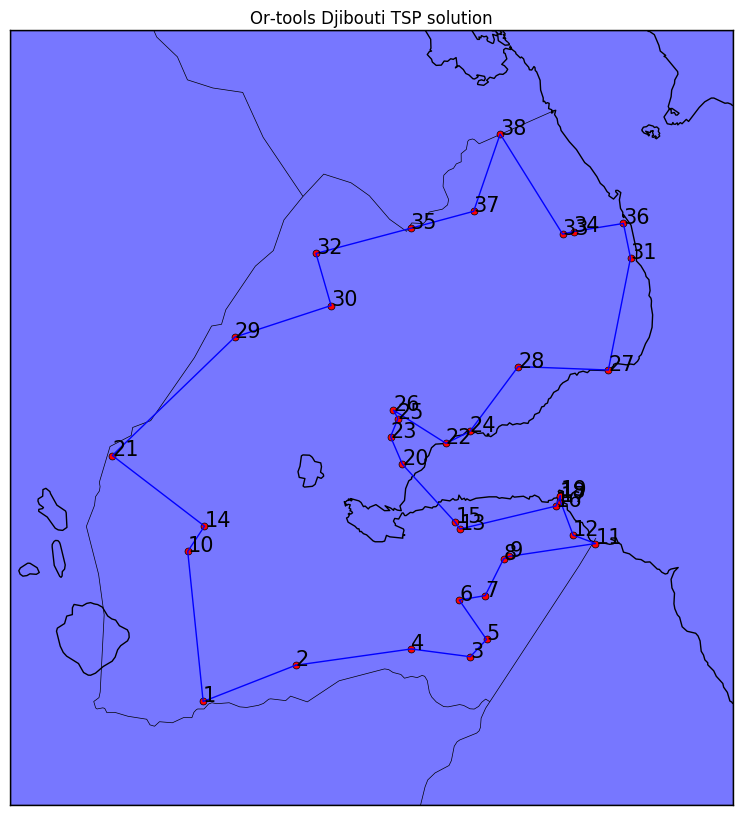

In [27]:
fig = plt.figure(figsize=(20,10))
plotPath(coordMat_latlong, ortoolsTour, 'Djibouti-ortools.pdf')

Route in Djibouti-gurobi.pdf : [1, 10, 14, 21, 29, 30, 32, 35, 37, 38, 33, 34, 36, 31, 27, 28, 24, 22, 25, 26, 23, 20, 15, 13, 16, 17, 18, 19, 11, 12, 9, 8, 7, 6, 5, 3, 4, 2, 1]


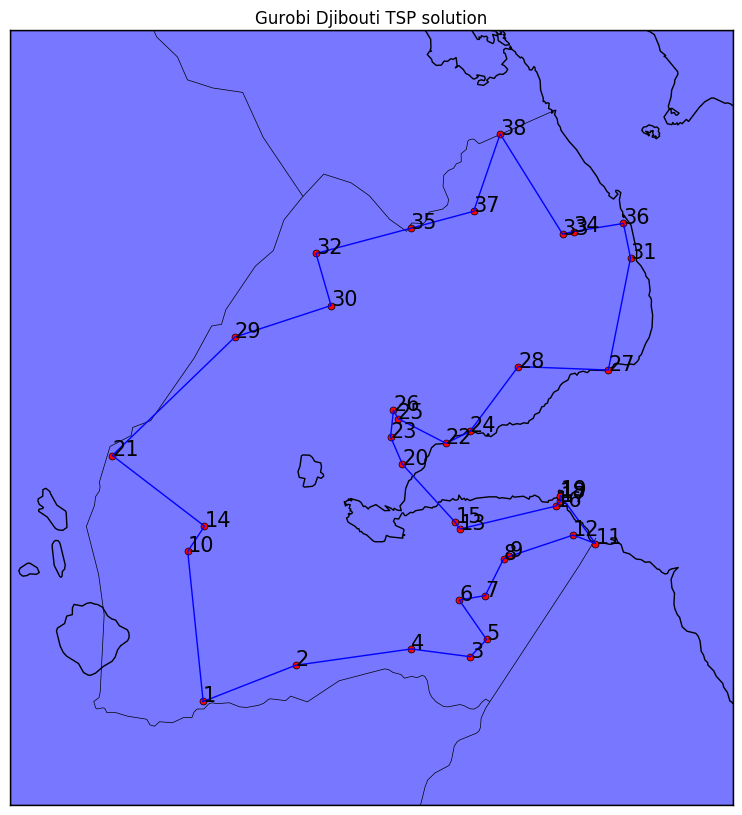

In [28]:
fig = plt.figure(figsize=(20,10))
plotPath(coordMat_latlong, gurobiTour, 'Djibouti-gurobi.pdf')

As can be seen, both tours are almost identical. In order to evaluate them we calculate the distance travelled in each tour.

In [24]:
sumDist = 0
for i in range(len(ortoolsTour) - 1):
    sumDist += havDistMat[ortoolsTour[i] - 1, ortoolsTour[i + 1] - 1]
print('ortools distance:', sumDist, 'km')

ortools distance: 732.443119224 km


In [25]:
sumDist = 0
for i in range(len(gurobiTour) - 1):
    sumDist += havDistMat[gurobiTour[i] - 1, gurobiTour[i + 1] - 1]
print('gurobi distance:', sumDist, 'km')

gurobi distance: 731.768852581 km


As can be seen, the Gurobi solver returns an optimal solution, which has better objective value than Google or-tools solution.